In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt 
import seaborn as sns

sns.set()

In [2]:
from scipy.stats import spearmanr

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import shap

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
from stop_permuting_features.src.generate_data import (
    generate_weights_gamma,
    get_correlated_data_stats, 
    generate_normal_correlated_data, 
    generate_normal_data, 
    generate_normal_target
)
from stop_permuting_features.src.calculate_importance import calculate_permutation_importance
from stop_permuting_features.src.utils import rank_array

# Config 

In [7]:
MU = 1 
VAR = 1
N_FEATUES = 35
N_SAMPLES = 10000


In [8]:
NOISE_MAGNITUDE_LOC = 3
NOISE_MAGNITUDE_SCALE = 1
SEED = 2020

# Generate data 

In [9]:
data = generate_normal_correlated_data(
    mu=MU,
    var=VAR,
    n_features=N_FEATUES,
    n_samples=N_SAMPLES,
    noise_magnitude_loc=NOISE_MAGNITUDE_LOC, 
    noise_magnitude_scale=NOISE_MAGNITUDE_SCALE,
    seed=SEED
)
data_stats = get_correlated_data_stats(data)
data_stats

{'correlation_min': 0.31552191804338386,
 'correlation_max': 0.855930926694185,
 'correlation_median': 0.524204582634421,
 'correlation_mean': 0.5332436894548418,
 'correlation_std': 0.09748985127110812,
 'abs_correlation_min': 0.31552191804338386,
 'abs_correlation_max': 0.855930926694185,
 'abs_correlation_median': 0.524204582634421,
 'abs_correlation_mean': 0.5332436894548418,
 'abs_correlation_std': 0.09748985127110812}

In [11]:
pd.DataFrame(data).corr()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.000000,0.412148,0.485031,0.515962,0.421213,0.512167,0.387563,0.426676,0.455279,0.429729,...,0.447533,0.389766,0.373865,0.491653,0.425572,0.374931,0.365476,0.410755,0.492545,0.441218
1,0.412148,1.000000,0.547627,0.571979,0.473359,0.557875,0.418817,0.473151,0.500322,0.483926,...,0.503088,0.440095,0.418549,0.547350,0.477813,0.415026,0.411773,0.461734,0.537750,0.487864
2,0.485031,0.547627,1.000000,0.679243,0.551988,0.665935,0.498172,0.559740,0.591148,0.561899,...,0.595286,0.506268,0.504096,0.646748,0.556373,0.486035,0.478331,0.541368,0.635227,0.582431
3,0.515962,0.571979,0.679243,1.000000,0.591314,0.703878,0.524414,0.585470,0.624845,0.593028,...,0.623104,0.541176,0.523799,0.674344,0.584975,0.513146,0.510455,0.561601,0.669692,0.610624
4,0.421213,0.473359,0.551988,0.591314,1.000000,0.580202,0.437884,0.480929,0.516016,0.493205,...,0.516220,0.444744,0.445734,0.558458,0.478757,0.417758,0.424318,0.476407,0.554207,0.508727
5,0.512167,0.557875,0.665935,0.703878,0.580202,1.000000,0.524051,0.583164,0.618478,0.591486,...,0.604322,0.540102,0.516034,0.666895,0.576439,0.500029,0.502493,0.568385,0.660642,0.598367
6,0.387563,0.418817,0.498172,0.524414,0.437884,0.524051,1.000000,0.430954,0.466338,0.443107,...,0.454352,0.406707,0.384221,0.506736,0.434329,0.370328,0.375000,0.422357,0.493094,0.455910
7,0.426676,0.473151,0.559740,0.585470,0.480929,0.583164,0.430954,1.000000,0.519391,0.497709,...,0.497318,0.444568,0.428854,0.562190,0.476527,0.420322,0.420292,0.455372,0.550203,0.500496
8,0.455279,0.500322,0.591148,0.624845,0.516016,0.618478,0.466338,0.519391,1.000000,0.527604,...,0.556153,0.475104,0.460434,0.597356,0.519193,0.445467,0.456851,0.501570,0.590517,0.544194
9,0.429729,0.483926,0.561899,0.593028,0.493205,0.591486,0.443107,0.497709,0.527604,1.000000,...,0.523109,0.459586,0.444990,0.565410,0.497723,0.432292,0.425460,0.476063,0.568761,0.507913


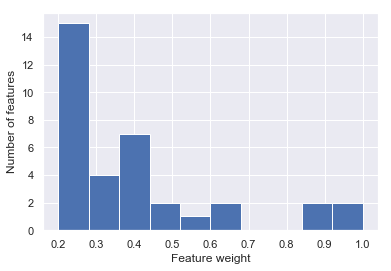

In [12]:
weights = generate_weights_gamma(n_features=data.shape[1], weights_range=(0.2, 1), seed=42)

plt.hist(weights)
plt.xlabel("Feature weight")
plt.ylabel("Number of features")
plt.show()

In [13]:
y = generate_normal_target(data, weights, task="classification")
data = pd.DataFrame(data)
np.mean(y)

0.5008

In [14]:
expected_ranks = rank_array(-weights)

# Test model importance 

### Permutation

In [15]:
model, score, importances, importance_ranks = calculate_permutation_importance(
    LGBMClassifier(n_estimators=100, learning_rate=0.01, random_state=42), 
    data, y, 
    scoring_function=roc_auc_score,
    n_repeats=3, 
)
permutation_ranks_corr = spearmanr(expected_ranks, importance_ranks)[0]

### SHAP 

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data)[0]
shap_values = abs(shap_values)
shap_fe = -shap_values.sum(axis=0)
shap_ranks_corr = spearmanr(expected_ranks, shap_fe)[0]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### Built-in gain

In [22]:
model_fe = model.booster_.feature_importance(importance_type='gain')
gain_ranks_corr = spearmanr(expected_ranks, -model_fe)[0]

## Results

In [23]:
print(f"Model's ROC-AUC score [train data]: {score:.4f}")
print(f"Permutation spearman corr: {permutation_ranks_corr:.4f}")
print(f"SHAP spearman corr: {shap_ranks_corr:.4f}")
print(f"LGB gain spearman corr: {gain_ranks_corr:.4f}")

Model's ROC-AUC score [train data]: 0.9493
Permutation spearman corr: 0.8415
SHAP spearman corr: 0.7863
LGB gain spearman corr: 0.8199


In [24]:
res = pd.DataFrame({})
res["weight"] = weights
res["expected_rank"] = expected_ranks
res["model_rank"] = importance_ranks
res = res.sort_values(by="expected_rank").reset_index(drop=True)
res

,weight,expected_rank,model_rank
0,1.000000,0,1
1,0.969466,1,0
2,0.886656,2,2
3,0.878287,3,3
4,0.657208,4,4
5,0.605571,5,5
6,0.548491,6,7
7,0.497683,7,10
8,0.478044,8,8
9,0.412607,9,19
